# Notebook 2: Na'vi River Journey EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import meanabs

import time

import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [2]:
navi_posted = pd.read_csv('data/navi_posted.csv')

In [3]:
navi_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
navi_posted['date'] = pd.to_datetime(navi_posted['date'])
navi_posted['datetime'] = pd.to_datetime(navi_posted['datetime'])
navi_posted['day_name'] = navi_posted.day_name.astype('string')


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
navi_date = navi_posted.copy()
navi_date.set_index('date', inplace=True)


navi_dt = navi_posted.copy()
navi_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = navi_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = navi_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = navi_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

navi_posted.set_index('date', inplace = True)

# EDA - Na'vi River Journey

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

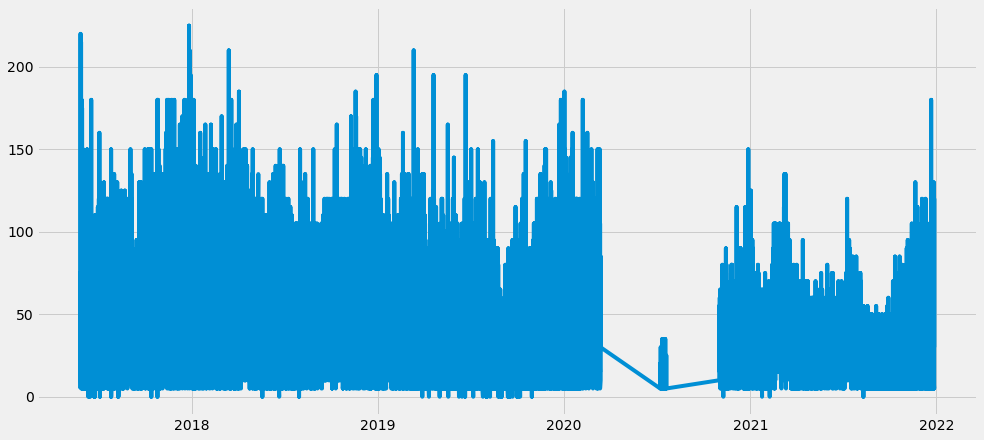

In [5]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(navi_posted['SPOSTMIN']);

In [6]:
print(f"Minimum Wait: {navi_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {navi_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 225.0


Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" is defined as prior to January 1, 2019.

In [7]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26
1,2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday,2017-05-26
2,2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday,2017-05-26
3,2017-05-26,2017-05-26 09:30:10,NaN,45.0,5,Friday,2017-05-26
4,2017-05-26,2017-05-26 09:45:32,NaN,45.0,5,Friday,2017-05-26


In [8]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2019-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,15.0,5,Friday,2017-05-26,38.896104
2017-05-27,2017-05-28 00:59:09,NaN,30.0,6,Saturday,2017-05-27,149.453125
2017-05-28,2017-05-29 00:59:05,NaN,25.0,7,Sunday,2017-05-28,115.821429
2017-05-29,2017-05-30 00:52:10,NaN,20.0,1,Monday,2017-05-29,103.867188
2017-05-30,2017-05-31 00:52:05,NaN,15.0,2,Tuesday,2017-05-30,92.500000


In [9]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,45.0,2,Tuesday,2019-07-16,74.019608
2019-07-17,2019-07-17 23:38:02,NaN,10.0,3,Wednesday,2019-07-17,49.824561
2019-07-18,2019-07-18 23:59:01,NaN,10.0,4,Thursday,2019-07-18,70.000000
2019-07-19,2019-07-19 21:59:02,NaN,20.0,5,Friday,2019-07-19,55.642202
2019-07-20,2019-07-20 21:59:02,NaN,15.0,6,Saturday,2019-07-20,65.752212


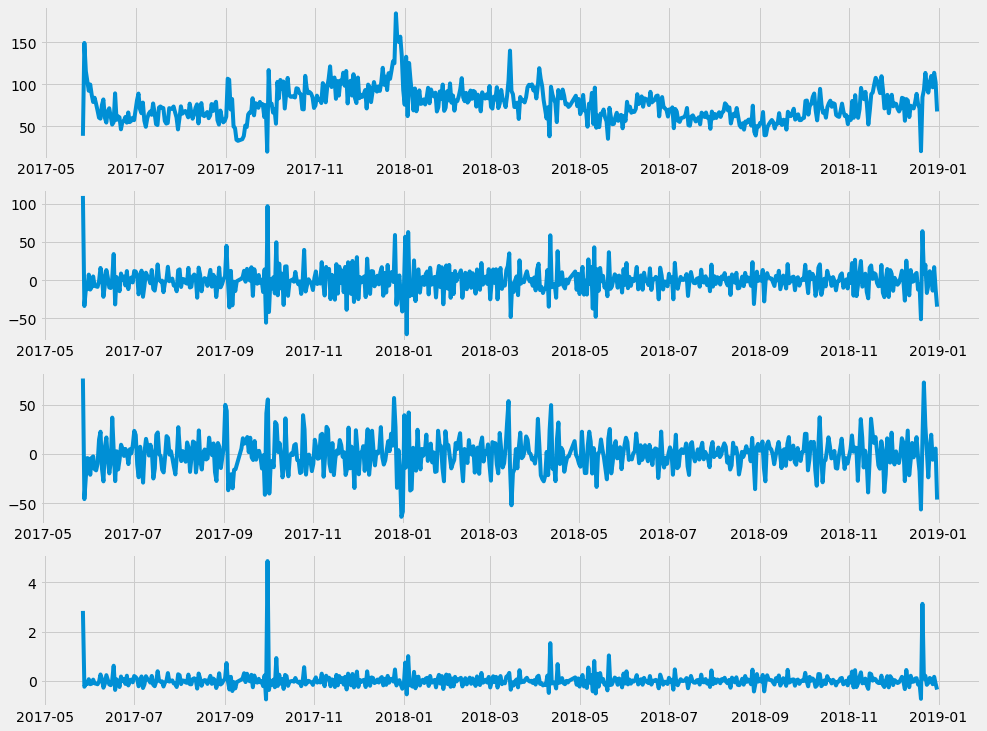

In [10]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  Note that time 0 = the day the ride opened, so that can be ignored.  But there are spikes in December, 2017 and December, 2019.  Covid might explain the lack of a spike in December, 2018.  Although the parks were open, global travel was ebbing, particularly travel from Asia.

The 4th plot (percent difference) indicates a spike in November.  This could be due to Thanksgiving as well as the beginning of summer holidays for countries in the Southern hemisphere.

Ultimately, there is some evidence of seasonality that I will investigate further in the modeling section.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

### Covid vs. Precovid

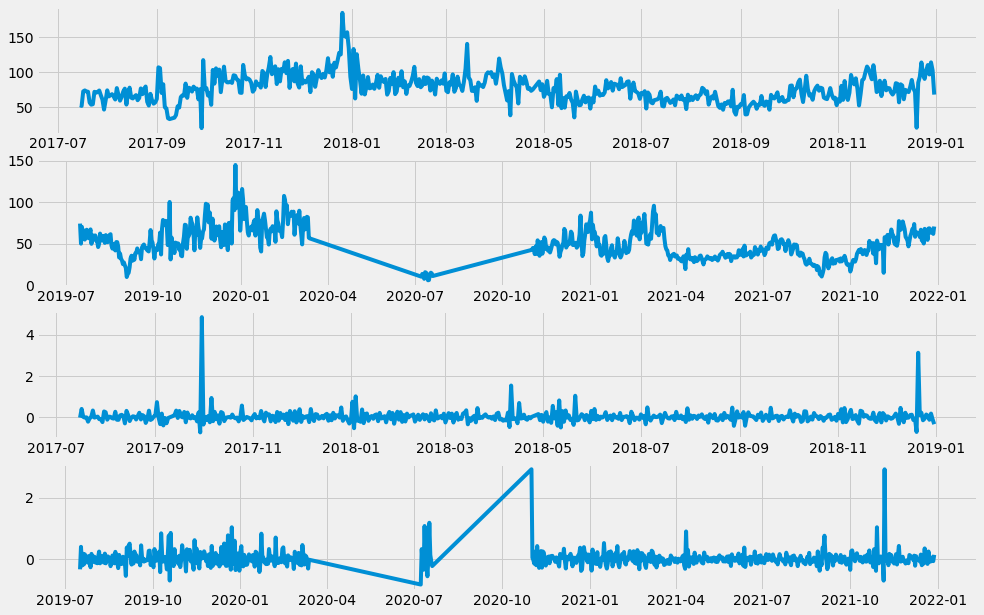

In [11]:
# to facilitate comparison, I'm starting both datasets at the same month for these plots.

precovid_daily_July = precovid_daily[precovid_daily['date2'] > '2017-07-14']

fig, axes = plt.subplots(nrows = 4, figsize = (15, 10))
axes[0].plot(precovid_daily_July['avg_daily_wait'])
axes[1].plot(covid['avg_daily_wait'])
axes[2].plot(precovid_daily_July['avg_daily_wait'].pct_change())
axes[3].plot(covid['avg_daily_wait'].pct_change());

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.  This is likely to have changed during covid after annual pass rules changed in 2021.

In 2021, Disney overhauled their annual passholder program.  In addition to steep price hikes, they require reservations for annual pass holders to ensure they won't exceed their lower park capacity (anywhere from  25%-50% of regular capacity, depending on the timing of the visit and the pandemic).  Reservations do not cost extra, but lower level passholders have limits on the number of reservations they can make each month; they also have additional blockout dates they never had before.

In [12]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       76.943606
Monday       78.895830
Saturday     78.542072
Sunday       72.975080
Thursday     76.873528
Tuesday      76.382354
Wednesday    72.910246
Name: avg_daily_wait, dtype: float64

Average daily wait time for the Na'vi River Journey was just over an hour before COVID.  Based on this summary, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 1 hour, do 8 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

In [13]:
# Covid-era seasonality based on day of the week
av_wait_by_day_of_week = covid.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       50.345402
Monday       51.167758
Saturday     52.937063
Sunday       51.617500
Thursday     49.382949
Tuesday      50.812495
Wednesday    46.184226
Name: avg_daily_wait, dtype: float64

Again, there's a minor difference in wait time among days.  Wednesdays have the shortest wait and Saturdays the longest, with a difference of about 7.5 minutes.  These numbers reflect the data plotted above.

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [14]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

navi_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
navi_Wed_Dec_05.set_index('datetime', inplace = True)

In [15]:
print(f"Minimum wait: {navi_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {navi_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 10.0
Maximum wait: 115.0


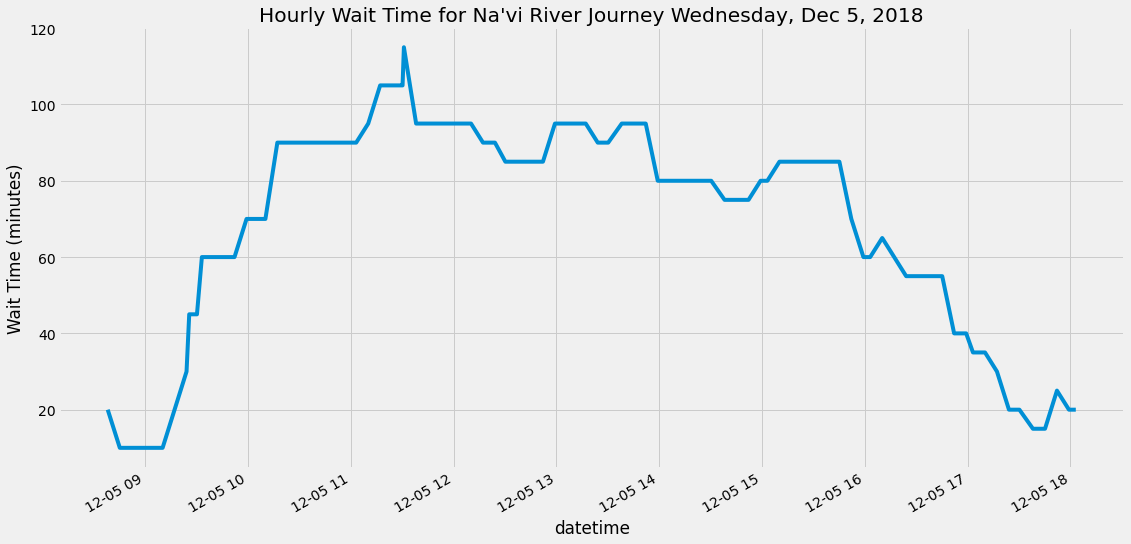

In [16]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

navi_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [17]:
# Step 3: Create data for Saturday, Dec 8, 2018

navi_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
navi_Sat_Dec_08.set_index('datetime', inplace = True)

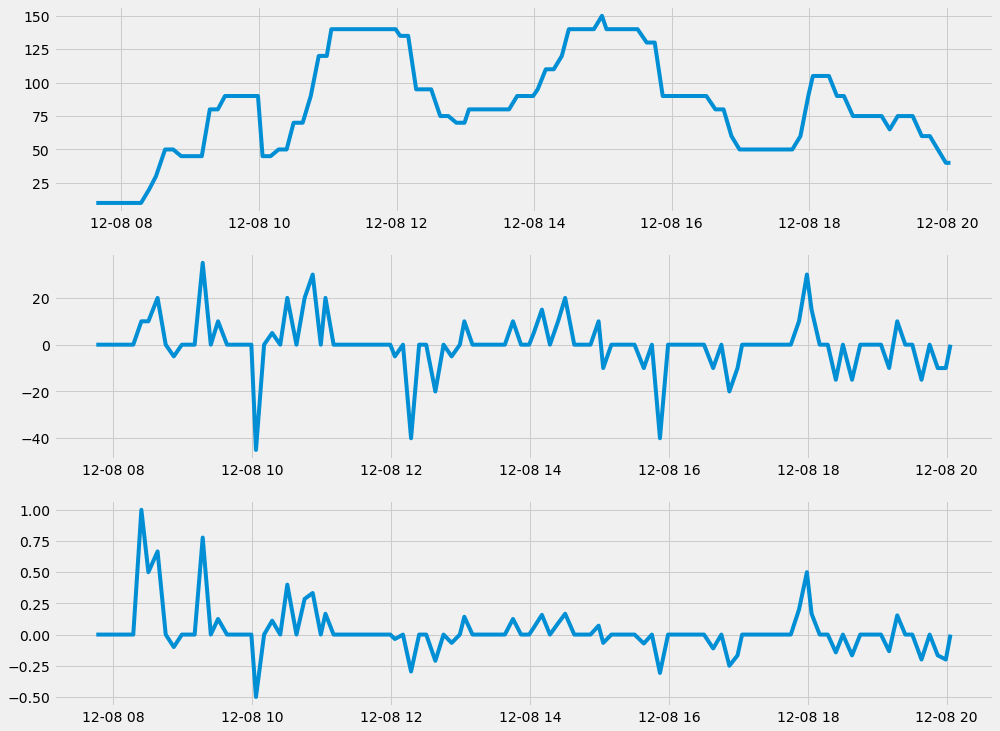

In [18]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(navi_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(navi_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(navi_Sat_Dec_08['SPOSTMIN'].pct_change());

In [19]:
print(f"Minimum wait: {navi_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {navi_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 10.0
Maximum wait: 150.0


The two hourly plots differ substantially.  The Wednesday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Saturday plot has several ebbs and flows, including two (around 10AM and 5-5:30PM) when the wait time drops to about 50 minutes.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

Comparing these two days provided no additional insight.  I need to compare all Saturdays to all Wednesdays to get a better idea if hourly seasonality exists.

In [20]:
# Step 5: Create df for Saturdays only
navi_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()

saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
77,2017-05-27,2017-05-27 07:17:06,NaN,30.0,6,Saturday
78,2017-05-27,2017-05-27 07:24:09,NaN,20.0,6,Saturday
79,2017-05-27,2017-05-27 07:30:11,NaN,70.0,6,Saturday
80,2017-05-27,2017-05-27 07:38:05,NaN,70.0,6,Saturday
81,2017-05-27,2017-05-27 07:45:10,NaN,70.0,6,Saturday


In [21]:
# Step 6: Create df for Wednesdays only
wednesdays = precovid.copy()

wednesdays = wednesdays[wednesdays['day_name'] == 'Wednesday']
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
613,2017-05-31,2017-05-31 08:03:31,NaN,60.0,3,Wednesday
614,2017-05-31,2017-05-31 08:10:10,NaN,30.0,3,Wednesday
615,2017-05-31,2017-05-31 08:17:17,NaN,75.0,3,Wednesday
616,2017-05-31,2017-05-31 08:24:10,NaN,75.0,3,Wednesday
617,2017-05-31,2017-05-31 08:30:15,NaN,75.0,3,Wednesday


In [22]:
saturdays['time'] = [d.time() for d in saturdays['datetime']]
wednesdays['time'] = [d.time() for d in wednesdays['datetime']]

In [23]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
77,2017-05-27,2017-05-27 07:17:06,NaN,30.0,6,Saturday,07:17:06
78,2017-05-27,2017-05-27 07:24:09,NaN,20.0,6,Saturday,07:24:09
79,2017-05-27,2017-05-27 07:30:11,NaN,70.0,6,Saturday,07:30:11
80,2017-05-27,2017-05-27 07:38:05,NaN,70.0,6,Saturday,07:38:05
81,2017-05-27,2017-05-27 07:45:10,NaN,70.0,6,Saturday,07:45:10


In [24]:
saturdays.dtypes

date        datetime64[ns]
datetime    datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [25]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
saturdays = saturdays[saturdays['time'] > temp_time]
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
84,2017-05-27,2017-05-27 08:03:05,NaN,90.0,6,Saturday,08:03:05
85,2017-05-27,2017-05-27 08:10:16,NaN,90.0,6,Saturday,08:10:16
86,2017-05-27,2017-05-27 08:17:08,NaN,90.0,6,Saturday,08:17:08
87,2017-05-27,2017-05-27 08:24:11,NaN,110.0,6,Saturday,08:24:11
88,2017-05-27,2017-05-27 08:30:13,NaN,110.0,6,Saturday,08:30:13


In [26]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
84,2017-05-27,2017-05-27 08:03:05,NaN,90.0,6,Saturday,08:03:05
85,2017-05-27,2017-05-27 08:10:16,NaN,90.0,6,Saturday,08:10:16
86,2017-05-27,2017-05-27 08:17:08,NaN,90.0,6,Saturday,08:17:08
87,2017-05-27,2017-05-27 08:24:11,NaN,110.0,6,Saturday,08:24:11
88,2017-05-27,2017-05-27 08:30:13,NaN,110.0,6,Saturday,08:30:13


In [27]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
wednesdays = wednesdays[wednesdays['time'] > temp_time]
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
613,2017-05-31,2017-05-31 08:03:31,NaN,60.0,3,Wednesday,08:03:31
614,2017-05-31,2017-05-31 08:10:10,NaN,30.0,3,Wednesday,08:10:10
615,2017-05-31,2017-05-31 08:17:17,NaN,75.0,3,Wednesday,08:17:17
616,2017-05-31,2017-05-31 08:24:10,NaN,75.0,3,Wednesday,08:24:10
617,2017-05-31,2017-05-31 08:30:15,NaN,75.0,3,Wednesday,08:30:15


In [28]:
# resample to 10 min intervals to drop seconds and standardize across Saturdays
saturdays.set_index('datetime', inplace=True)
saturdays.resample('10min', loffset=pd.Timedelta('10min'))


/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_2821/2061199249.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  saturdays.resample('10min', loffset=pd.Timedelta('10min'))


In [29]:
saturdays.dtypes

date        datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [30]:
saturdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2017-05-27 08:03:05,2017-05-27,NaN,90.0,6,Saturday,08:03:05
2017-05-27 08:10:16,2017-05-27,NaN,90.0,6,Saturday,08:10:16
2017-05-27 08:17:08,2017-05-27,NaN,90.0,6,Saturday,08:17:08
2017-05-27 08:24:11,2017-05-27,NaN,110.0,6,Saturday,08:24:11
2017-05-27 08:30:13,2017-05-27,NaN,110.0,6,Saturday,08:30:13


In [31]:
saturdays.set_index('time', inplace=True)


In [32]:
wednesdays.set_index('datetime', inplace=True)
wednesdays.resample('10min', loffset=pd.Timedelta('10min'))

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_2821/2490914169.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  wednesdays.resample('10min', loffset=pd.Timedelta('10min'))


In [33]:
wednesdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2017-05-31 08:03:31,2017-05-31,NaN,60.0,3,Wednesday,08:03:31
2017-05-31 08:10:10,2017-05-31,NaN,30.0,3,Wednesday,08:10:10
2017-05-31 08:17:17,2017-05-31,NaN,75.0,3,Wednesday,08:17:17
2017-05-31 08:24:10,2017-05-31,NaN,75.0,3,Wednesday,08:24:10
2017-05-31 08:30:15,2017-05-31,NaN,75.0,3,Wednesday,08:30:15


In [34]:
wednesdays.set_index('time', inplace=True)

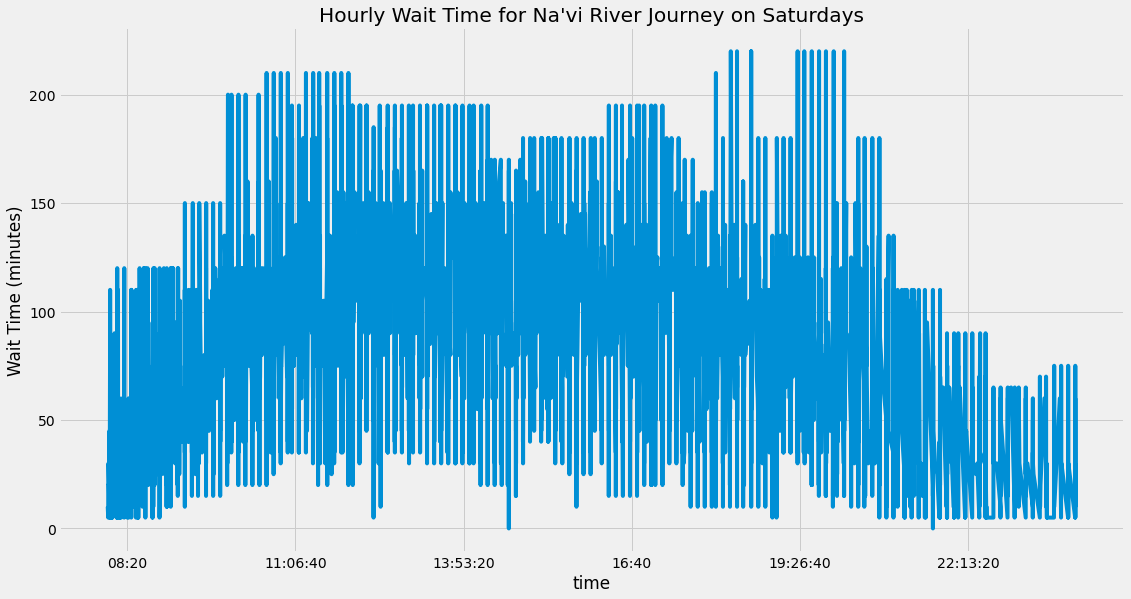

In [35]:
# Step 7: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be hourly seasonality for this ride, but the vast majority of wait times exceed 1hr, 40 minutes.  Therefore, in terms of guests' experience, the wait time differences mean little.  Of course, everyone has different tolerances for waiting, but people traveling from afar who are already spending thousands on a Disney vacation probably will prefer to pay $15 per person for Genie+ than spend a precious 1 hr and 40 min waiting for 1 ride.

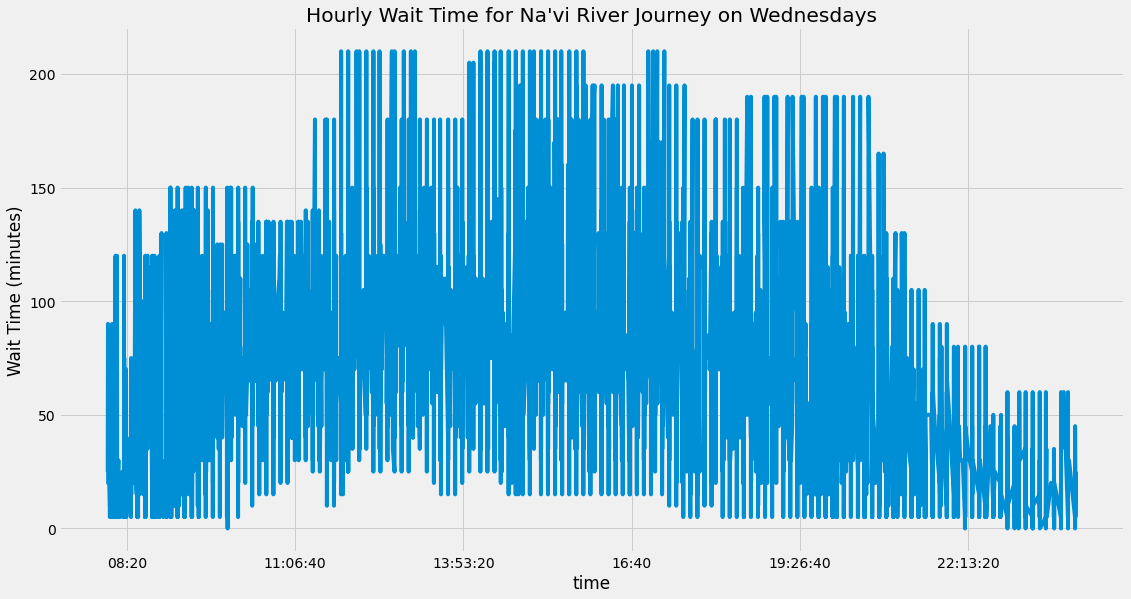

In [36]:
# Step 7: Plot hourly data for all Wednesdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey on Wednesdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

wednesdays['SPOSTMIN'].plot();

Overall, the darker pattern in this plot resembles the darker pattern in the Saturdays plot.  There might be hourly seasonality for this ride, but it's so popular that its wait times are at 2 hours by 9am.  Note that often the park opens at 9am.  In a few years, once the ride is no longer new, hourly seasonality might be something to revisit.  Currently, there might be hourly patterns, but any dips still indicate waits of 90 minutes or more until the end of the park day.

I see occasional gaps where the wait might be dropping (or it could be missing data for that time interval).  On the few days when the park was open late (Animal Kingdom is seldom open later than 8), wait times drop around 10pm.  Still, avoiding a 1 hour or more wait requires getting in line at the perfect time (approximately 10:30pm), which is a gamble, since they will close the ride before the wait oversteps the park's closure.  Much of Animal Kingdom is less viewable after dark.  Na'vi River Journey is an indoor ride, so it's unaffected by outside darkness.  And, of course, families with younger children won't want to stay this late, so Avatar fans should strongly consider purchasing an individual Lightning Lane pass for this ride.

## Weekly Seasonality

Weekly seasonality must be considered, but it's tricky because spring break and Thanksgiving dates shift each year.  Spring break dates can shift by as much as 6 weeks.  Therefore, a customized approach is warranted.

First, I'll number each week of the year, beginning with the day after the Christmas - New Year's blockout dates end.  Week numbers for the first year will align with the calendar, aside from the brief offset for New Year's blockout dates.  For subsequent years, spring break weeks - as defined by Disney's blockout dates - will be switched to align with the first years.  In other words, spring breaks will always have the same week numbers, regardless of where they fall in the calendar.  I'll do the same with Thanksgiving and, if necessary, Christmas.

I realize this isn't a perfect system.  K-12 school districts tend to align to Easter; colleges and universities do not.  However, using Disney's self-declared blockout dates for lower-level passholders makes the system as equivalent as possible.

Another issue with this method is covid's timing.  Na'vi River Journey opened May 26, 2017, so it was only open for 1.5 years before covid began impacting tourism.  Therefore, for this ride and for Flight of Passage, I'll focus solely on August 1 - Dec 31 of 2017, 2018, 2019, and 2020.

In [37]:
precovid.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday
1,2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday
2,2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday
3,2017-05-26,2017-05-26 09:30:10,NaN,45.0,5,Friday
4,2017-05-26,2017-05-26 09:45:32,NaN,45.0,5,Friday


In [38]:
# navi_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']

In [39]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# Create two copies: one for future indexing and one for other uses
precovid_weekly['week_number'] = precovid_weekly['week_num']

precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_num,week_number
date,,,,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,15.0,5,Friday,2017-05-26,38.896104,0,0,0
2017-05-27,2017-05-28 00:59:09,NaN,30.0,6,Saturday,2017-05-27,149.453125,1,0,0
2017-05-28,2017-05-29 00:59:05,NaN,25.0,7,Sunday,2017-05-28,115.821429,2,0,0
2017-05-29,2017-05-30 00:52:10,NaN,20.0,1,Monday,2017-05-29,103.867188,3,0,0
2017-05-30,2017-05-31 00:52:05,NaN,15.0,2,Tuesday,2017-05-30,92.500000,4,0,0


In [40]:
# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(83, 10)

In [41]:
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2017-06-01,2017-06-02 01:03:06,NaN,10.0,4,Thursday,2017-06-01,87.866667,6,0,98.343502
2017-06-08,2017-06-09 01:03:07,NaN,10.0,4,Thursday,2017-06-08,75.526316,13,1,72.110169
2017-06-15,2017-06-16 01:03:06,NaN,0.0,4,Thursday,2017-06-15,52.254902,20,2,64.533198
2017-06-22,2017-06-23 01:03:08,NaN,20.0,4,Thursday,2017-06-22,55.544872,27,3,61.076240
2017-06-29,2017-06-30 01:03:06,NaN,20.0,4,Thursday,2017-06-29,60.312500,34,4,58.719537


In [42]:
# Had to copy data first before limiting by date.  Didn't work when I tried to combine steps.
Aug17 = precovid_weekly.copy()
Aug18 = precovid_weekly.copy()

Aug17 = Aug17[Aug17['date2'] > '2017-07-31']
Aug17 = Aug17[Aug17['date2'] <= '2017-12-31']
Aug18 = Aug18[Aug18['date2'] > '2018-07-31']
Aug18 = Aug18[Aug18['date2'] <= '2018-12-31']

In [43]:
Aug18.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-07,2018-08-07 21:30:08,NaN,15.0,2,Tuesday,2018-08-07,68.076923,433,61,64.591463
2018-08-14,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,65.252101,440,62,67.893321
2018-08-21,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,46.229508,447,63,56.547535
2018-08-28,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,43.705357,454,64,56.568639
2018-09-04,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,39.576271,461,65,50.624389


In [44]:
# Between covid and the ride opening in May, 2017, week_number in all Aug dfs must be 
# calibrated to be in sync with each other

Aug17['week_number'] = Aug17['week_number'] - 9
Aug18['week_number'] = Aug18['week_number'] - 61

In [45]:
Aug18.head(20)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-07,2018-08-07 21:30:08,NaN,15.0,2,Tuesday,2018-08-07,68.076923,433,0,64.591463
2018-08-14,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,65.252101,440,1,67.893321
2018-08-21,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,46.229508,447,2,56.547535
2018-08-28,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,43.705357,454,3,56.568639
2018-09-04,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,39.576271,461,4,50.624389
2018-09-11,2018-09-11 20:06:19,NaN,10.0,2,Tuesday,2018-09-11,47.616822,468,5,51.054133
2018-09-18,2018-09-18 19:59:08,NaN,10.0,2,Tuesday,2018-09-18,56.952381,475,6,56.245527
2018-09-25,2018-09-25 20:03:06,NaN,20.0,2,Tuesday,2018-09-25,58.190476,482,7,62.210757
2018-10-02,2018-10-02 19:59:07,NaN,20.0,2,Tuesday,2018-10-02,80.514706,489,8,62.938050


In [46]:
# Thanksgiving, 2017 = Nov 23; Thanksgiving, 2018 = Nov 22.  They have the same week number.

In [47]:
# copy dataframe for backup
covid_weekly = covid.copy()


# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()


,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2019-07-22,2019-07-22 23:59:02,NaN,5.0,1,Monday,2019-07-22,5.0,6,0,17.857143
2019-07-29,2019-07-29 23:59:02,NaN,15.0,1,Monday,2019-07-29,15.0,13,1,18.571429
2019-08-05,2019-08-05 23:59:02,NaN,5.0,1,Monday,2019-08-05,5.0,20,2,27.857143
2019-08-12,2019-08-12 23:59:02,NaN,10.0,1,Monday,2019-08-12,10.0,27,3,13.571429
2019-08-19,2019-08-19 23:59:02,NaN,5.0,1,Monday,2019-08-19,5.0,34,4,12.857143


In [48]:
Aug19 = covid_weekly.copy()
Aug20 = covid_weekly.copy()

Aug19 = Aug19[Aug19['date2'] > '2019-07-31']
Aug19 = Aug19[Aug19['date2'] <= '2019-12-31']
Aug20 = Aug20[Aug20['date2'] > '2020-07-31']
Aug20 = Aug20[Aug20['date2'] <= '2020-12-31']

# Offsets needed to sync up Thanksgiving to same week number (roughly)
Aug19['week_number'] = Aug19['week_number'] - 2
Aug20['week_number'] = Aug20['week_number'] - 24

In [49]:
Aug20.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2020-11-04,2020-11-04 17:10:01,NaN,20.0,3,Wednesday,2020-11-04,20.0,258,12,16.428571
2020-11-11,2020-11-11 16:59:02,NaN,35.0,3,Wednesday,2020-11-11,35.0,265,13,25.000000
2020-11-18,2020-11-18 16:59:01,NaN,25.0,3,Wednesday,2020-11-18,25.0,272,14,31.428571
2020-11-25,2020-11-25 20:03:01,NaN,20.0,3,Wednesday,2020-11-25,20.0,279,15,29.285714
2020-12-02,2020-12-02 16:52:44,NaN,25.0,3,Wednesday,2020-12-02,25.0,286,16,26.428571


### Weekly EDA

In [50]:
precovid_weekly.set_index('date2', inplace=True)

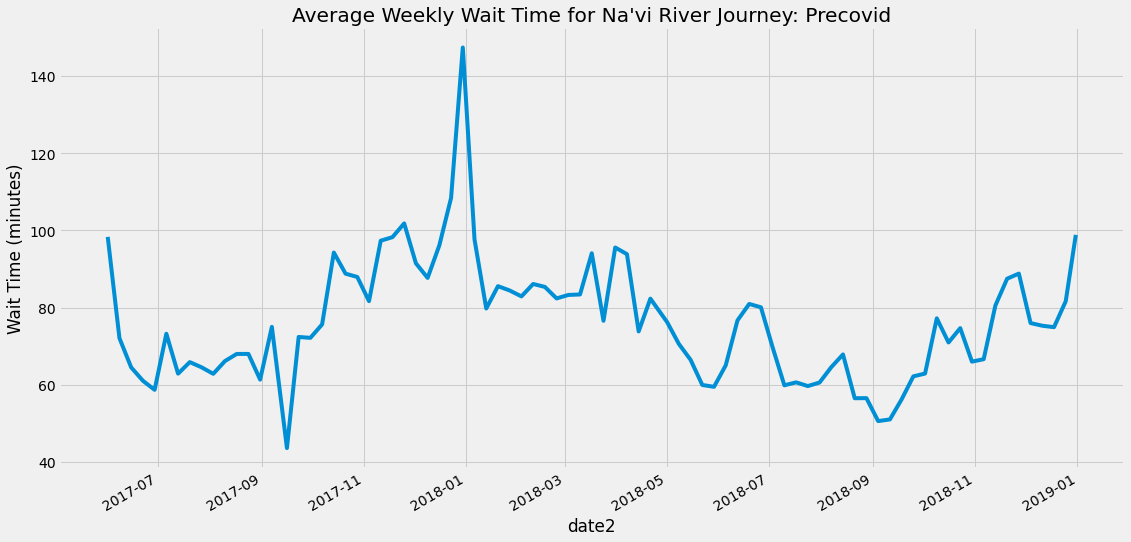

In [51]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Na'vi River Journey: Precovid")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is definite weekly fluctuation, but it doesn't appear to form a clear pattern.  The major spike at December, 2017 is due to higher park attendance at Christmas. There are similar, though smaller, spikes in November and December, 2018.  In Florida, summer vacation begins in mid-May and ends in early to mid-August.  The smaller spikes in late May, 2018 and 2019 likely are due to summer vacation for local schoolchildren.

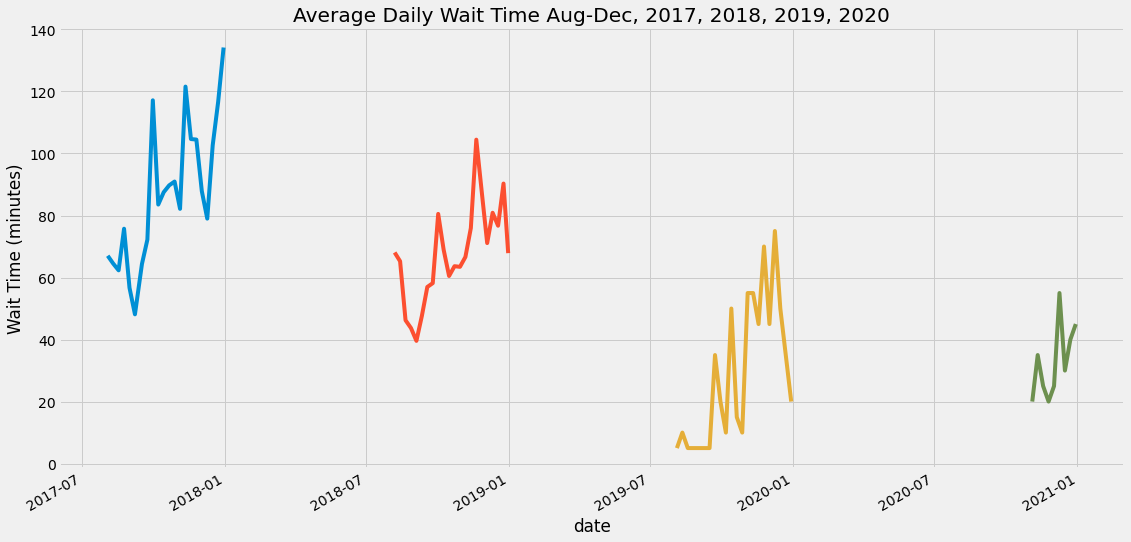

In [52]:
plt.figure(figsize = (17, 9))
plt.title("Average Daily Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_daily_wait'].plot()
Aug18['avg_daily_wait'].plot()
Aug19['avg_daily_wait'].plot()
Aug20['avg_daily_wait'].plot();

The trends appear very similar.  December 2018 and 2020 appear more affected by covid than December 2020.  At least in Autumn, there is seasonality.  The biggest difference among the plots is that average daily wait time decreased each year from 2017-2019 and leveled off in 2020.

In [53]:
Aug17.set_index('week_number', inplace=True)
Aug18.set_index('week_number', inplace=True)
Aug19.set_index('week_number', inplace=True)
Aug20.set_index('week_number', inplace=True)

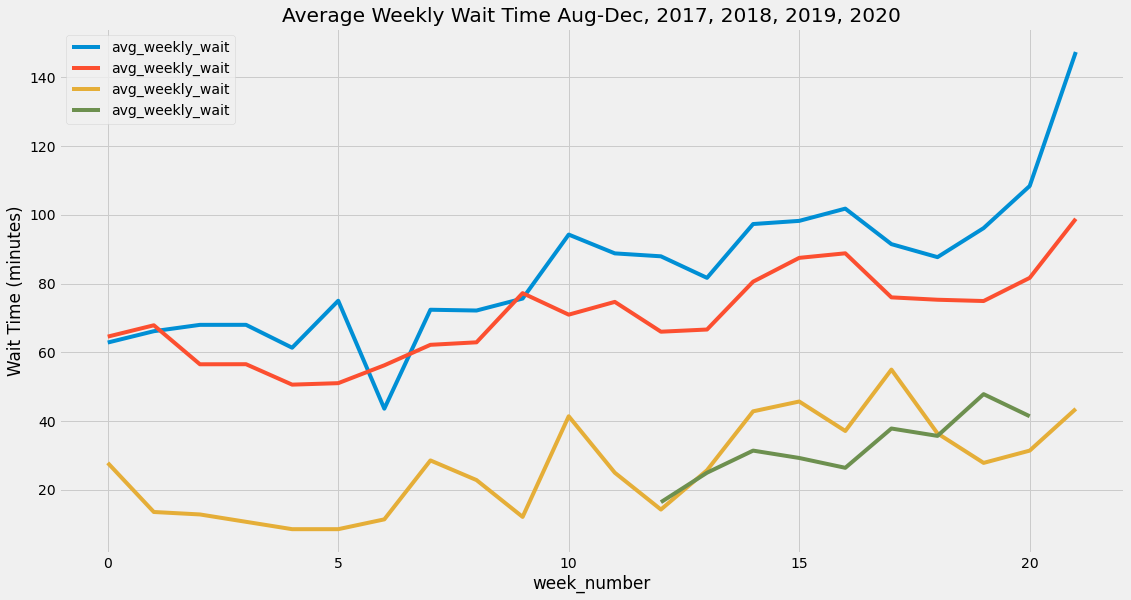

In [54]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_weekly_wait'].plot()
Aug18['avg_weekly_wait'].plot()
Aug19['avg_weekly_wait'].plot()
Aug20['avg_weekly_wait'].plot()
plt.legend();

By calibrating all years by week number, I can plot the average daily wait times on the same graph.  2017 and 2018 look very similar.  Wait times were higher in 2017, but since the ride was new in 2017, that makes sense.  The lower spike at the end of 2018 could be due to covid.  Covid began impacting tourism, especially from Asia, by the end of 2018.

2020 is missing a lot of data, but what is available roughly follows the pattern of 2019.  

# Modeling

## Precovid Null Model

In [55]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

70.21449434910376

In this case, the null model is the mean wait time before covid, or 70 minutes.  I calculated this figure using the original data but excluding all dates after March 15, 2020.

In [56]:
precovid_weekly_2 = precovid_weekly.copy()

In [57]:
# for prediction purposes, I want a one year dataset unaffected by covid and the ride's grand opening
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] > '2017-08-01']
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] < '2018-08-01']
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-03,2017-08-03 23:59:06,NaN,5.0,4,Thursday,67.021277,69,9,62.869778
2017-08-10,2017-08-11 00:03:07,NaN,10.0,4,Thursday,64.510490,76,10,66.172267
2017-08-17,2017-08-18 00:03:07,NaN,5.0,4,Thursday,62.323944,83,11,68.017657
2017-08-24,2017-08-24 21:30:09,NaN,30.0,4,Thursday,75.736434,90,12,68.025941
2017-08-31,2017-08-31 21:30:10,NaN,10.0,4,Thursday,56.694215,97,13,61.365357


In [58]:
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-03,2017-08-03 23:59:06,NaN,5.0,4,Thursday,67.021277,69,9,62.869778
2017-08-10,2017-08-11 00:03:07,NaN,10.0,4,Thursday,64.510490,76,10,66.172267
2017-08-17,2017-08-18 00:03:07,NaN,5.0,4,Thursday,62.323944,83,11,68.017657
2017-08-24,2017-08-24 21:30:09,NaN,30.0,4,Thursday,75.736434,90,12,68.025941
2017-08-31,2017-08-31 21:30:10,NaN,10.0,4,Thursday,56.694215,97,13,61.365357


## Covid Null Model

In [59]:
# Overall average wait time during covid
covid_null = covid[covid['date2'] < '2021-09-01']
covid_null['SPOSTMIN'].mean()

27.352415026833633

In [60]:
covid.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,45.0,2,Tuesday,2019-07-16,74.019608
2019-07-17,2019-07-17 23:38:02,NaN,10.0,3,Wednesday,2019-07-17,49.824561
2019-07-18,2019-07-18 23:59:01,NaN,10.0,4,Thursday,2019-07-18,70.000000


## ACF and PACF Plots

### 1 Year Plots

All of these plots use data that starts in August, 2017.

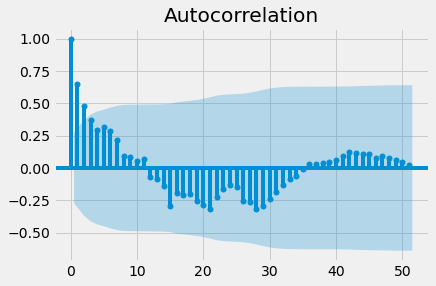

In [61]:
# Weekly ACF plot for May 26, 2017 - May 26, 2018: pre-covid
# X-axis = week number
plot_acf(precovid_weekly_2['avg_weekly_wait'], lags=51)
plt.show()

This plot shows indications of seasonality, with significant autocorrelation for almost 3 weeks, followed by what looks like a subtle cosine curve.

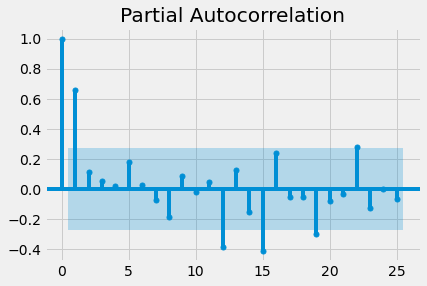

In [62]:
# Weekly PACF plot for May 26, 2017 - May 26, 2018: pre-covid
plot_pacf(precovid_weekly_2['avg_weekly_wait'], lags=25)
plt.show()

The partial autocorrelation plot also shows indications of seasonality, roughly 6 months after August.  Aside from a positive blip for Presidents' Day week, February is a pretty quiet month for Disney.

### 90 Day ACF and PACF Plots

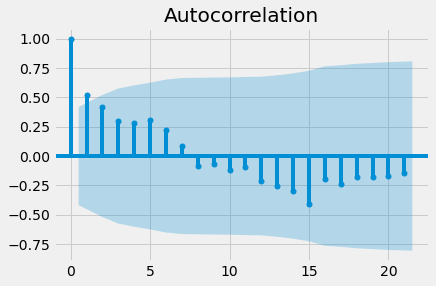

In [63]:
# 5 month plot, beginning Aug 1, 2017 (roughly 5 months)
plot_acf(Aug17['avg_weekly_wait'], lags=21)
plt.show()

Autocorrelation really only lasts for 2 weeks.  It flips from positive to negative in early October and only begins to approch zero again approaching New Year's.  Since the curve dips and increases again, this might be evidence of seasonality.

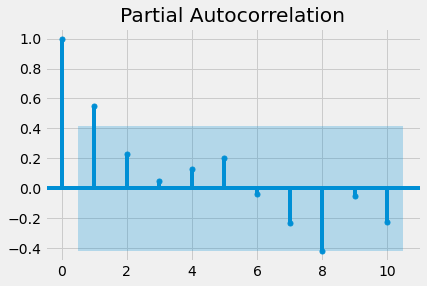

In [64]:
# 13 Week plot beginning Aug 1, 2017 (roughly 3 months)
plot_pacf(Aug17['avg_weekly_wait'], lags=10)
plt.show()

Partial autocorrelation is only observed the first two weeks (as expected) and then negatively at the 8th interval.

In [65]:
Aug18.head(25)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_number,,,,,,,,,
0,2018-08-07 21:30:08,NaN,15.0,2,Tuesday,2018-08-07,68.076923,433,64.591463
1,2018-08-14 21:30:10,NaN,10.0,2,Tuesday,2018-08-14,65.252101,440,67.893321
2,2018-08-21 21:30:09,NaN,5.0,2,Tuesday,2018-08-21,46.229508,447,56.547535
3,2018-08-28 20:30:10,NaN,10.0,2,Tuesday,2018-08-28,43.705357,454,56.568639
4,2018-09-04 20:30:11,NaN,5.0,2,Tuesday,2018-09-04,39.576271,461,50.624389
5,2018-09-11 20:06:19,NaN,10.0,2,Tuesday,2018-09-11,47.616822,468,51.054133
6,2018-09-18 19:59:08,NaN,10.0,2,Tuesday,2018-09-18,56.952381,475,56.245527
7,2018-09-25 20:03:06,NaN,20.0,2,Tuesday,2018-09-25,58.190476,482,62.210757
8,2018-10-02 19:59:07,NaN,20.0,2,Tuesday,2018-10-02,80.514706,489,62.938050


### Decomposition

In [66]:
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,15.0,5,Friday,2017-05-26,38.896104
2017-05-27,2017-05-28 00:59:09,NaN,30.0,6,Saturday,2017-05-27,149.453125
2017-05-28,2017-05-29 00:59:05,NaN,25.0,7,Sunday,2017-05-28,115.821429
2017-05-29,2017-05-30 00:52:10,NaN,20.0,1,Monday,2017-05-29,103.867188
2017-05-30,2017-05-31 00:52:05,NaN,15.0,2,Tuesday,2017-05-30,92.500000


<Figure size 432x288 with 0 Axes>

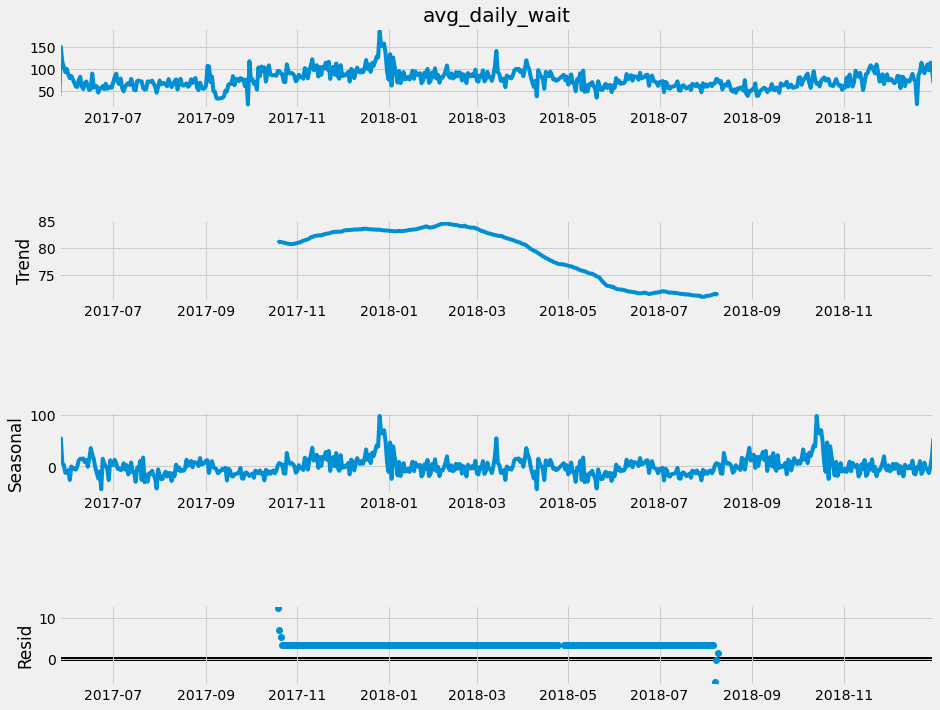

In [67]:
# Daily seasonality?

decomp_daily = seasonal_decompose(precovid_daily.avg_daily_wait, period = 289)
fig = plt.figure()
fig = decomp_daily.plot()
fig.set_size_inches(15, 12);

Decomposition of average daily wait times shows the potential for seasonality.  The spike in Dec, 2017 is completely expected.  The spike in mid-October, 2018 is not.  Disney does not publish its park attendance numbers, so I cannot see if park attendance spiked during that time.  Data for the other rides might shed some light on this.

Residuals are minimal, so any prediction models should be pretty accurate.

### Due to small data set, delete weekly stuff below this line from this notebook

<Figure size 432x288 with 0 Axes>

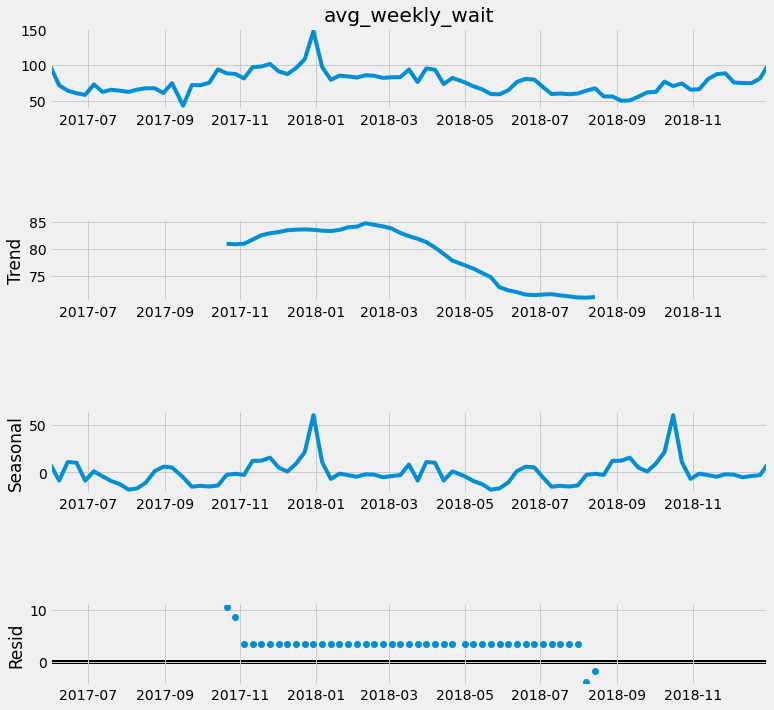

In [68]:
# Weekly seasonality?

decomp_weekly = seasonal_decompose(precovid_weekly.avg_weekly_wait, period = 41)
fig = plt.figure()
fig = decomp_weekly.plot()
fig.set_size_inches(12, 12);


The weekly decomposition plots look very similar to the daily decomposition plots.  The daily decomposition doesn't add any granularity.

In [69]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2017-06-01,98.343502
2017-06-08,72.110169
2017-06-15,64.533198
2017-06-22,61.076240
2017-06-29,58.719537
...,...
2018-11-29,85.172730
2018-12-06,75.820355
2018-12-13,75.218854


In [70]:
covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
covid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date,
2019-07-22,17.857143
2019-07-29,18.571429
2019-08-05,27.857143
2019-08-12,13.571429
2019-08-19,12.857143
...,...
2021-11-29,36.836735
2021-12-06,34.897959
2021-12-13,33.265306


In [71]:
# covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

In [72]:
#covid.tail(50)

There are insufficient data and too many large gaps to predict wait times on a weekly basis, so I must use daily data.  The next question is which "precovid" data to use: 2018, 2019, or 2020?  The parks were closed from mid-March - mid-July, 2019.  Disney is still not running at full capacity, so if those data are availble, they might predict wait times better than 2018 data.  I lack the data for 2020, so that's not an option.

## Predict Wait Times for Autumn, 2021

### Option 1 (Null Model):
Remember, the null model is that guests will wait 29 minutes to ride this ride.

### Option 2: ARIMA

In [73]:
# Modify dfs to make them the same length[Aug 30 - Oct 31, 2021 & Aug 30 - Oct 31, 2019]
y_train = covid[covid['date2'] > '2019-08-29']
y_train = y_train[y_train['date2'] < '2019-12-29']
y_test = covid[covid['date2'] > '2021-08-29']

In [74]:
y_train.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-08-30,2019-08-30 21:24:02,NaN,5.0,5,Friday,2019-08-30,25.125000
2019-08-31,2019-08-31 21:31:02,NaN,10.0,6,Saturday,2019-08-31,27.190083
2019-09-01,2019-09-01 21:24:02,NaN,5.0,7,Sunday,2019-09-01,23.608696
2019-09-02,2019-09-02 21:31:02,NaN,5.0,1,Monday,2019-09-02,20.762712
2019-09-03,2019-09-03 13:59:02,NaN,10.0,2,Tuesday,2019-09-03,9.561404


In [75]:
y_test.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2021-08-30,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,12.900000
2021-08-31,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,12.602041
2021-09-01,2021-09-01 18:59:07,NaN,5.0,3,Wednesday,2021-09-01,10.190476
2021-09-02,2021-09-02 18:59:07,NaN,5.0,4,Thursday,2021-09-02,14.029126
2021-09-03,2021-09-03 18:59:08,NaN,5.0,5,Friday,2021-09-03,18.809524


Aug 30, 2019 was a Friday; Aug 30, 2021 was a Monday.  I need to modify the dataframes and index them by day_number (new field), so that the days of the week match up, even though actual dates will differ by a few days.

I would start y_train on Monday, Sept 2, 2019 instead of August 30, but that was Labor Day. Sept 6, 2021 was Labor Day.  There's no perfect way to adjust for this.  I'll manually recode the respective dates as Sundays instead of Mondays to predict crowds better.  The plots won't match, but in the final analysis (predicting actual wait times vs predicted), it will be fine.

In [76]:
# Add day_number and make it index in both dfs

y_train['day_number'] = range(1, 1 + len(y_train))
y_test['day_number'] = range(1, 1 + len(y_test))

y_train.set_index('day_number', inplace=True)
y_test.set_index('day_number', inplace=True)

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_2821/3422483454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['day_number'] = range(1, 1 + len(y_test))


In [77]:
y_train

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2019-08-30 21:24:02,NaN,5.0,5,Friday,2019-08-30,25.125000
2,2019-08-31 21:31:02,NaN,10.0,6,Saturday,2019-08-31,27.190083
3,2019-09-01 21:24:02,NaN,5.0,7,Sunday,2019-09-01,23.608696
4,2019-09-02 21:31:02,NaN,5.0,1,Monday,2019-09-02,20.762712
5,2019-09-03 13:59:02,NaN,10.0,2,Tuesday,2019-09-03,9.561404
...,...,...,...,...,...,...,...
117,2019-12-24 20:59:02,NaN,80.0,2,Tuesday,2019-12-24,104.705882
118,2019-12-25 20:59:02,NaN,65.0,3,Wednesday,2019-12-25,90.247934
119,2019-12-26 20:59:02,NaN,90.0,4,Thursday,2019-12-26,144.695122


In [78]:
y_test

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,12.900000
2,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,12.602041
3,2021-09-01 18:59:07,NaN,5.0,3,Wednesday,2021-09-01,10.190476
4,2021-09-02 18:59:07,NaN,5.0,4,Thursday,2021-09-02,14.029126
5,2021-09-03 18:59:08,NaN,5.0,5,Friday,2021-09-03,18.809524
...,...,...,...,...,...,...,...
117,2021-12-24 19:58:48,NaN,30.0,5,Friday,2021-12-24,63.000000
118,2021-12-25 19:58:39,NaN,45.0,6,Saturday,2021-12-25,66.694215
119,2021-12-26 20:00:26,NaN,45.0,7,Sunday,2021-12-26,65.534351


In [79]:
# For use in future, custom model
custom_21 = y_test.copy()

In [80]:
# These are daily data.
y_train = pd.DataFrame(y_train['avg_daily_wait'])
y_test = pd.DataFrame(y_test['avg_daily_wait'])

In [81]:
# From lesson 9.3, Hank Butler
# start with really high AIC, initialize p and q to zero
# loop through to find best aic, p, and q
# Starting AIC, p, and q.

best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = y - variable
                         order = (p, 1, q)) # values of p, d, q
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index

Attempting to fit ARIMA(0, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20716D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.207D+00
  F =   4.2071640184708290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,0) is: 1013.719364432999
Attempting to fit ARIMA(0, 1, 1)


 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06334D+00    |proj g|=  1.84412D-03

At iterate    5    f=  4.06333D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   8.882D-08   4.063D+00
  F =   4.0633285859467190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,1) is: 981.1988606272126
Attempting to fit ARIMA(0, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec


At iterate    5    f=  4.01565D+00    |proj g|=  1.91083D-03

At iterate   10    f=  4.01565D+00    |proj g|=  1.03917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.882D-08   4.016D+00
  F =   4.0156508184369981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,4) is: 975.7561964248796
Attempting to fit ARIMA(1, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10409D+00    |proj g|=  1.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05982D+00    |proj g|=  3.62297D-03

At iterate    5    f=  4.05923D+00    |proj g|=  1.99156D-03

At iterate   10    f=  4.05921D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   8.882D-08   4.059D+00
  F =   4.0592079114647781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,2) is: 984.2098987515467
Attempting to fit ARIMA

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsu

The AIC for ARIMA(1,1,3) is: 986.1992238423938
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06684D+00    |proj g|=  2.30074D-03

At iterate    5    f=  4.06682D+00    |proj g|=  3.61489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   8.882D-08   4.067D+00
  F =   4.0668234986182110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2

 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     45      1     0     0   9.059D-06   4.039D+00
  F =   4.0394050500508270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,1) is: 979.4572120121984
Attempting to fit ARIMA(2, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05959D+00    |proj g|=  3.39027D-03

At iterate    5    f=  4.05915D+00    |proj g|=  1.50546D-04

At iterate   10    f=  4.05915D+00    |proj g|=  8.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Attempting to fit ARIMA(2, 1, 4)
Attempting to fit ARIMA(3, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06675D+00    |proj g|=  2.34088D-03

At iterate    5    f=  4.06672D+00    |proj g|=  2.32259D-04

At iterate   10    f=  4.06672D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   8.882D-08   4.067D+00
  F =   4.0667232998693033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec


At iterate   25    f=  4.03049D+00    |proj g|=  1.61293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     52      1     0     0   1.613D-04   4.030D+00
  F =   4.0304899808107013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,1) is: 979.3175953945682
Attempting to fit ARIMA(3, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03517D+00    |proj g|=  3.09934D-02

At iterate    5    f=  4.03001D+00    |proj g|=  1.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   10    f=  4.00123D+00    |proj g|=  2.88347D-03

At iterate   15    f=  4.00037D+00    |proj g|=  1.67538D-02

At iterate   20    f=  3.99988D+00    |proj g|=  1.75694D-02

At iterate   25    f=  3.99978D+00    |proj g|=  7.03704D-04

At iterate   30    f=  3.99978D+00    |proj g|=  3.78586D-04

At iterate   35    f=  3.99978D+00    |proj g|=  9.33920D-05

At iterate   40    f=  3.99978D+00    |proj g|=  5.86198D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     65      1     0     0   8.304D-06   4.000D+00
  F =   3.9997769723882728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index w

The AIC for ARIMA(4,1,0) is: 987.4667631639329
Attempting to fit ARIMA(4, 1, 1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05372D+00    |proj g|=  6.72085D-03

At iterate    5    f=  4.04890D+00    |proj g|=  1.76124D-02

At iterate   10    f=  4.03885D+00    |proj g|=  1.79233D-02

At iterate   15    f=  4.02683D+00    |proj g|=  2.16581D-02

At iterate   20    f=  4.02620D+00    |proj g|=  1.28004D-03

At iterate   25    f=  4.02617D+00    |proj g|=  7.03437D-05

At iterate   30    f=  4.02617D+00    |proj g|=  1.62803D-04

At iterate   35    f=  4.02617D+00    |proj g|=  2.78888D-05

At iterate   40    f=  4.02617D+00    |proj g|=  1.77636D-06

At iterate   45    f=  4.02617D+00    |proj g|=  1.08358D-05

At iterate   50    f=  4.02617D+00    |proj g|=  7.10543D-07

At iterate   55    f=  4.02617D+00    |proj g|=  2.66454D-07

At itera

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12545D+00    |proj g|=  1.37864D+00

At iterate    5    f=  4.03432D+00    |proj g|=  1.73288D-02

At iterate   10    f=  4.02911D+00    |proj g|=  5.59236D-02

At iterate   15    f=  4.02676D+00    |proj g|=  2.68451D-02

At iterate   20    f=  4.02494D+00    |proj g|=  3.21414D-03

At iterate   25    f=  4.02491D+00    |proj g|=  6.49782D-03

At iterate   30    f=  4.02491D+00    |proj g|=  1.50990D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   10    f=  4.00804D+00    |proj g|=  6.14929D-02

At iterate   15    f=  3.99985D+00    |proj g|=  2.64977D-02

At iterate   20    f=  3.99960D+00    |proj g|=  2.51243D-02

At iterate   25    f=  3.99858D+00    |proj g|=  2.31442D-02

At iterate   30    f=  3.99853D+00    |proj g|=  2.16071D-02

At iterate   35    f=  3.99829D+00    |proj g|=  3.73261D-03

At iterate   40    f=  3.99806D+00    |proj g|=  2.02263D-02

At iterate   45    f=  3.99798D+00    |proj g|=  2.39506D-03

At iterate   50    f=  3.99798D+00    |proj g|=  3.04023D-04

At iterate   55    f=  3.99798D+00    |proj g|=  4.02345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [82]:
# Since dataset is small, do manually.  No seasonality, just straight-up ARIMA
#factors = pmd.auto_arima(y_train['avg_daily_wait'], m=31, trace=True)

# best model = AIC =975.756; (0, 1, 4)

In [83]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(),
             order = (0, 1, 4))


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01984D+00    |proj g|=  1.15322D-01

At iterate    5    f=  4.01565D+00    |proj g|=  1.91083D-03

At iterate   10    f=  4.01565D+00    |proj g|=  1.03917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.882D-08   4.016D+00
  F =   4.0156508184369981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [84]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.avg_daily_wait   No. Observations:                  120
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -481.878
Method:                       css-mle   S.D. of innovations             13.192
Date:                Fri, 14 Jan 2022   AIC                            975.756
Time:                        12:34:53   BIC                            992.481
Sample:                             1   HQIC                           982.548
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4277      0.070      6.111      0.000       0.291       0.565
ma.L1.D.avg_daily_wait    -0.6901      0.084     -8.237      0.000      -0.854      -0.526
ma.L2.D.avg_daily_wait     0.0610      0.107      0.571      0.568      -0.148       0.270
ma.L3.D.avg_daily_wait     0.0421      0.096      0.436      0.663      -0.147       0.231
ma.L4.D.avg_daily_wait    -0.4129      0.091     -4.534      0.000      -0.591      -0.234
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.2948           -1.2413j            1.2758           -0.2129
MA.3            0.2948           +1.2413j            1.2758            0.2129
MA.4           -1.4878           -0.0000j            1.4878           -0.5000
-----------------------------------------------------------------------------
"""

In [85]:
# RMSE ranges from .084 to .107, constant = .070

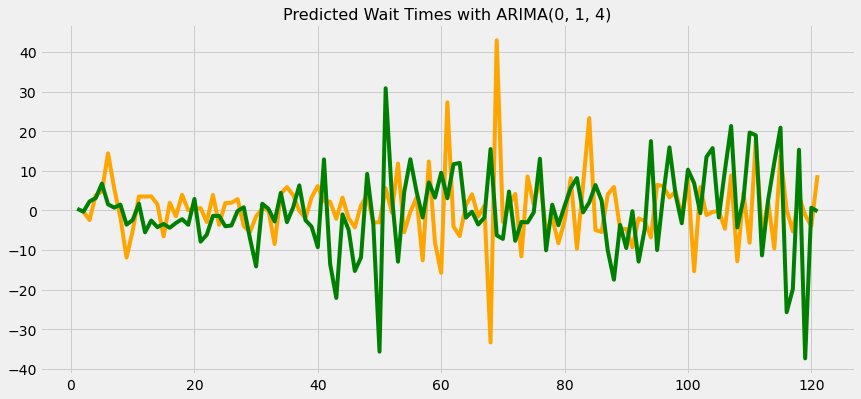

In [135]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(1), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

The blue line represents 2019 (train) data; the orange line represents 2021 (test) data. The green line represents the predicted wait times.

To plot the two time series on the same timeframe, I replaced the respective date indices with a day_number index, beginning on Aug 30 and ending on Oct 31 of the respective years.

The model predicts wait times fairly well for roughly the first 38 days.  After that, it predicts downward and upward spikes about 10 days too soon; the predicted downward spike is also more severe than the actual one. Time series models typically don't forecast well beyond 30-60 days.  Given the further limitations of the data and COVID as a disruptor, I'm satisfied with my model.

Overall, it appears visitors can anticipate shorter wait times in Autumn, 2021 and (likely) until the covid pandemic wanes globally. Alternatively, until park capacity is increased, wait times will remain shorter. 

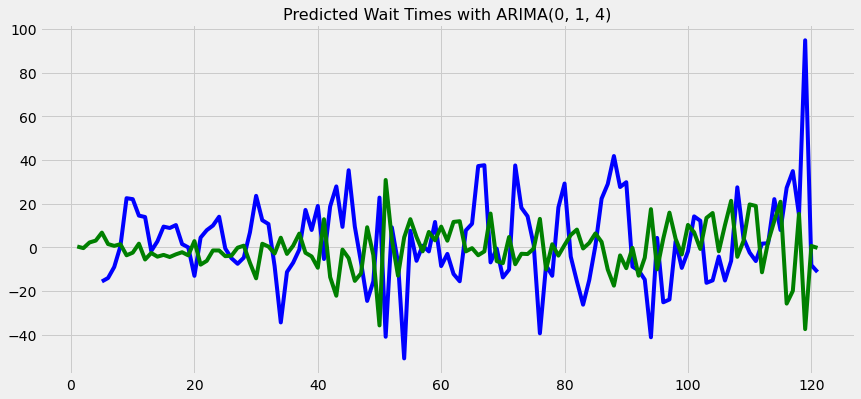

In [136]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(4), color = 'blue')

# Plot testing data.
#plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

The blue line represents the 2019 training data; the green line represents the actual 2021 (test) data.

In [88]:
adfuller(y_train['avg_daily_wait'])

(-1.9754930040603151,
 0.2974208440602563,
 2,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 882.2300437452266)

### DELETE THE WEEKLY ADFULLER

In [89]:
adfuller(precovid_weekly_3['avg_weekly_wait'])

(-3.6888230173261816,
 0.004273143562937623,
 0,
 82,
 {'1%': -3.512738056978279,
  '5%': -2.8974898650628984,
  '10%': -2.585948732897085},
 543.3917121358478)

In [90]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 121
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   avg_daily_wait  121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


With an alpha of .05 and a p-value of .30, the y_train (2019) data are not stationary. The small dataframe size might account for this.  However, because of the dataframe's size (n = 121), SARIMAX is not an option for this ride or for Flights of Passage.  It will be an interesting test for Kiliminjaro Safaris and Everest Expeditions (those rides have been operating much longer).

### Mean Absolute Error

In [91]:
#preds_df = pd.DataFrame(arima)
#preds_df.head()

In [92]:
# print(f'Mean absolute error: {preds_df.mae}')
# print(f'Mean squared error: {preds_df.mse}')

Both mean absolute error and mean squared error are low.  This indicates that the model is strong, perhaps because of the high degree of autocorrelation.

In [93]:
# print(preds.summary())

In [94]:
# Convert preds to df column for app

### Option 3:  Custom Model

The average wait time for Na'vi River Journey during covid is about 43 min shorter than precovid.  Since there is some seasonality based on day of the week, it would be worthwhile to calculate the differences in average waits by day of the week.

Goal: Predict wait times for fall, 2021

Normally, I would rely on differences in long-term averages to calculate an offset to predict wait times on unseen covid-era data based on precovid-era data.  However, this doesn't seem to work in this case.  Ride wait times are impacted by more than just covid.  They're also impacted by who is visiting the parks.  While global tourism is rebounding, it's not rebounding at the same rate for all countries.  Moreover, domestic tourism has remained leery of Florida because of its high covid rates compared with other states.  Trips to Disney are planned months ahead of time.  Because of all of the unique factors involved in predicting wait times for 2021, a custom model might be warranted.

I'm going (attempt) to predict the average daily wait time for Na'vi River Journey using the average covid wait time adjusted by day of the week.  I'll use percentage differences to calculate the offsets in minutes.  I realize this is unorthodox, but these are not conventional times.

If I worked for Disney, I'd rely heavily on company-imposed park capacities.

In [95]:
# Create day of week adjustments (i.e. offsets)
fri = (76.9 - 55.2) / 76.9
mon = (78.9 - 54.9) / 78.9
sat = (78.5 - 57.0) / 78.5
sun = (73.0 - 55.9) / 73.0
thu = (76.9 - 51.2) / 76.9
tue = (76.4 - 53.7) / 76.4
wed = (72.9 - 47.1) / 72.9

In [96]:
# create dataframe from previous df
# keep date col, posted wait time, and day of week
# add col for adjustment
# add col to calc prediction (av covid wait time - av covid wait time * adjustment)

In [97]:
custom_19 = covid[['date2', 'SPOSTMIN', 'weekday', 'day_name', 'avg_daily_wait']]

In [98]:
# limit date range to match dates selected in model 2

custom_19 = custom_19[custom_19['date2'] > '2019-08-29']
custom_19 = custom_19[custom_19['date2'] < '2019-12-29']

In [99]:
# df['new'] = pd.Series(dtype='your_required_dtype')
custom_19['offset'] = pd.Series(dtype='float')

In [100]:
fri = (76.9 - 55.2) / 76.9
mon = (78.9 - 54.9) / 78.9
sat = (78.5 - 57.0) / 78.5
sun = (73.0 - 55.9) / 73.0
thu = (76.9 - 51.2) / 76.9
tue = (76.4 - 53.7) / 76.4
wed = (72.9 - 47.1) / 72.9

def add_offset(row):
    if row['weekday'] == 1:
        return mon
    elif row['weekday'] == 2:
        return tue
    elif row['weekday'] == 3:
        return wed
    elif row['weekday'] == 4:
        return thu
    elif row['weekday'] == 5:
        return fri
    elif row['weekday'] == 6:
        return sat
    elif row['weekday'] == 7:
        return sun

custom_19['offset'] = custom_19.apply(add_offset, axis = 1)

# with help from https://stackoverflow.com/questions/58740265/create-new-column-in-pandas-using-if-statement

In [101]:
custom_19['day_number'] = range(1, 1 + len(custom_19))
custom_19.set_index('day_number', inplace=True)

In [102]:
custom_19.head()

,date2,SPOSTMIN,weekday,day_name,avg_daily_wait,offset
day_number,,,,,,
1,2019-08-30,5.0,5,Friday,25.125000,0.282185
2,2019-08-31,10.0,6,Saturday,27.190083,0.273885
3,2019-09-01,5.0,7,Sunday,23.608696,0.234247
4,2019-09-02,5.0,1,Monday,20.762712,0.304183
5,2019-09-03,10.0,2,Tuesday,9.561404,0.297120


In [103]:
custom_19.tail()

,date2,SPOSTMIN,weekday,day_name,avg_daily_wait,offset
day_number,,,,,,
117,2019-12-24,80.0,2,Tuesday,104.705882,0.297120
118,2019-12-25,65.0,3,Wednesday,90.247934,0.353909
119,2019-12-26,90.0,4,Thursday,144.695122,0.334200
120,2019-12-27,15.0,5,Friday,93.898305,0.282185
121,2019-12-28,20.0,6,Saturday,93.478261,0.273885


In [104]:
# Calculate daily wait for the customized model (i.e. reduce avg_daily_wait by % offset)
# Note: custom_daily_wait applies to the same date in 2021, NOT the date in the current df
custom_19['custom_daily_wait'] = (1 - custom_19['offset']) * custom_19['avg_daily_wait']

In [105]:
# Change wait time, offset, and recalculate custom_daily_wait
custom_19.at[4, 'avg_daily_wait'] = 23.608696
custom_19.at[4, 'offset'] = sun
custom_19.at[4, 'custom_daily_wait'] = 23.608696 * (1 - sun)

In [106]:
custom_19.head()

,date2,SPOSTMIN,weekday,day_name,avg_daily_wait,offset,custom_daily_wait
day_number,,,,,,,
1,2019-08-30,5.0,5,Friday,25.125000,0.282185,18.035111
2,2019-08-31,10.0,6,Saturday,27.190083,0.273885,19.743117
3,2019-09-01,5.0,7,Sunday,23.608696,0.234247,18.078440
4,2019-09-02,5.0,1,Monday,23.608696,0.234247,18.078440
5,2019-09-03,10.0,2,Tuesday,9.561404,0.297120,6.720515


In [107]:
# Create df for custom_daily_wait
custom_19_2 = custom_19[['custom_daily_wait', 'day_name']]

In [108]:
custom_19_2['day_number'] = range(1, 1 + len(custom_19_2))
custom_19_2.set_index('day_number', inplace=True)

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_2821/98413013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  custom_19_2['day_number'] = range(1, 1 + len(custom_19_2))


In [109]:
custom_19_2

,custom_daily_wait,day_name
day_number,,
1,18.035111,Friday
2,19.743117,Saturday
3,18.078440,Sunday
4,18.078440,Monday
5,6.720515,Tuesday
...,...,...
117,73.595627,Tuesday
118,58.308336,Wednesday
119,96.337975,Thursday


In [110]:
custom_21.head(8)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,12.900000
2,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,12.602041
3,2021-09-01 18:59:07,NaN,5.0,3,Wednesday,2021-09-01,10.190476
4,2021-09-02 18:59:07,NaN,5.0,4,Thursday,2021-09-02,14.029126
5,2021-09-03 18:59:08,NaN,5.0,5,Friday,2021-09-03,18.809524
6,2021-09-04 18:55:23,NaN,25.0,6,Saturday,2021-09-04,33.238095
7,2021-09-05 18:59:07,NaN,35.0,7,Sunday,2021-09-05,38.774510
8,2021-09-06 19:01:42,NaN,30.0,1,Monday,2021-09-06,37.018349


Aug 30, 2021 was a Friday, but August 30, 2019 was a Monday.

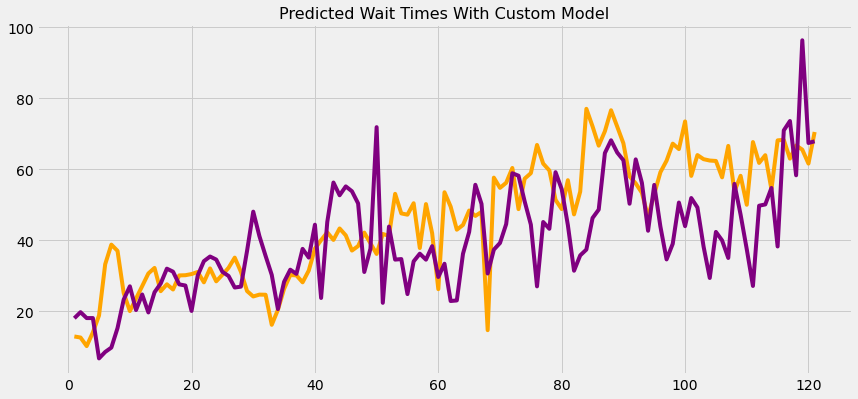

In [111]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot customized values
plt.plot(custom_19_2.index, custom_19_2['custom_daily_wait'], color = 'purple')

# Plot predicted test values.
# plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times With Custom Model', fontsize=16)
plt.show();

The purple line represents the wait times predicted by the custom model.  The orange line represents the actual wait times.  The prediction appears to get most of the trends right (up vs down) and does pretty well until about 90 days out.

In [112]:
# Calculate MAE and MSE
# print(f'Mean absolute error: {preds_df.mae}')
# print(f'Mean squared error: {preds_df.mse}')

## Choose Best Model

In [113]:
# Calculate MSE and MAE for null model
# custom_19_2['day_number'] = range(1, 1 + len(custom_19_2))
# Remember, the null model is that guests will wait 29 minutes to ride this ride.

In [114]:
# Create dataframe with null_wait and avg_daily_wait so I can calculate MAE and MSE

all_models = custom_21.copy()
all_models['null_wait'] = 29
all_models = all_models[['null_wait', 'avg_daily_wait']]
all_models.head()

# Note: the first 'avg_daily_wait' field is for 2021

,null_wait,avg_daily_wait
day_number,,
1,29,12.900000
2,29,12.602041
3,29,10.190476
4,29,14.029126
5,29,18.809524


In [115]:
# MSE and MAE for Null Model

all_models['mse_null'] = (all_models['null_wait'] - all_models['avg_daily_wait']) ** 2

all_models['mae_null'] = abs(all_models['null_wait'] - all_models['avg_daily_wait'])


In [125]:
# Add custom_daily_wait column
all_models['custom_daily_wait'] = custom_19['custom_daily_wait']

# MSE and MAE for Custom Model

all_models['mse_custom'] = (all_models['custom_daily_wait'] - all_models['avg_daily_wait']) ** 2

all_models['mae_custom'] = abs(all_models['custom_daily_wait'] - all_models['avg_daily_wait'])


In [117]:
# MSE and MAE for null model
null_mse = (all_models['mse_null']).sum()
print(f'Null MSE = {null_mse}')

null_mae = (all_models['mae_null']).sum() / len(all_models)
print(f'Null MAE = {null_mae}')

Null MSE = 66644.72107999495
Null MAE = 19.21750171057104


In [130]:
preds

array([  0.42774058,  -0.31249318,   2.28434394,   3.12085702,
         6.78579653,   1.5383987 ,   0.71494467,   1.47968864,
        -3.58477826,  -2.39119535,   1.723334  ,  -5.52785864,
        -2.53795549,  -4.21958644,  -3.41218141,  -4.37804313,
        -3.1600684 ,  -2.19649858,  -3.61636067,   2.8960585 ,
        -7.8711639 ,  -6.13615472,  -1.37318906,  -1.38248247,
        -3.99028455,  -3.79173456,  -0.1219766 ,   0.80825256,
        -7.03698363, -14.13373252,   1.69037492,   0.39932989,
        -2.79437149,   4.45483381,  -2.95990711,   0.76194112,
         6.33437128,  -2.45496682,  -4.10823721,  -9.28995389,
        12.89950535, -13.55600394, -22.09337331,  -0.98538215,
        -4.91115423, -15.29047924, -11.87897638,   9.23133956,
        -3.49837183, -35.66466477,  30.85604866,   3.7590885 ,
       -12.93483554,   4.57984908,  12.9298656 ,   4.7800366 ,
        -1.79369256,   7.0929033 ,   3.25737882,   9.52290224,
         3.07870992,  11.67921357,  11.99602877,  -1.80

In [140]:
# df = pd.DataFrame(series)
preds_df = pd.DataFrame(preds)
preds_df.columns = ['pred_off']
preds_df

,pred_off
0,0.427741
1,-0.312493
2,2.284344
3,3.120857
4,6.785797
...,...
116,-19.869586
117,15.334872
118,-37.357268
119,0.684758


In [152]:
# MSE and MAE for ARIMA
# Add column with ARIMA predictions
preds_df['pred_sq'] = (preds_df['pred_off'])**2
arima_mse = (preds_df['pred_sq']).sum()

preds_df['preds_abs'] = abs(preds_df['pred_off'])
arima_mae = (preds_df['preds_abs']).sum() / len(preds_df)

print(f"ARIMA MSE = {arima_mse}")
print(f"ARIMA MAE = {arima_mae}")


ARIMA MSE = 12799.438346425028
ARIMA MAE = 7.291493599295581


In [119]:
custom_mse = (all_models['mse_custom']).sum()
print(f'Custom MSE = {custom_mse}')

custom_mae = (all_models['mae_custom']).sum() / len(all_models)
print(f'Custom MAE = {custom_mae}')

Custom MSE = 28655.22251983681
Custom MAE = 12.041635642039212


Based on the MSEs, the custom model is much better than the null model.

The RMSE for the ARIMA model ranges from .084 to .107.  This seems too good to be true, but I'll take it.  The small RMSE could be due to the small df size; I only predicted 121 days out.  Most time series analysis does satisfactorily up to 90 days out.

However, the ARIMA model solidly beats the custom model.  The ARIMA MSE is less than half of the custom model's MSE, and the MAE is also considerably lower.

### Weekly Stuff (possibly for older rides)

In [120]:
covid_weekly['month'] = pd.DatetimeIndex(covid_weekly['date2']).month

In [121]:
covid_weekly_3 = covid_weekly[['avg_weekly_wait']]
covid_weekly_3.head()

,avg_weekly_wait
date,
2019-07-22,17.857143
2019-07-29,18.571429
2019-08-05,27.857143
2019-08-12,13.571429
2019-08-19,12.857143


In [122]:
# Predictions
start_index = 0
end_index = len(covid_weekly_3)
forecast = navi_results.predict(start=start_index, end=end_index)


NameError: name 'navi_results' is not defined

In [ ]:
predictions = pd.DataFrame(forecast)
predictions.head()

In [ ]:
df_final = precovid_weekly_3.merge(predictions, left_on='date2', right_on='date2')

In [ ]:
df_final.head()

In [ ]:
df_final['resids'] = df_final['predicted_mean'] - df_final['avg_weekly_wait']

In [ ]:
df_final.mean()

In [ ]:
plt.figure(figsize = (17, 9))
plt.title("Predicted vs Posted Wait Times for Na'vi River Journey")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')

df_final['avg_weekly_wait'].plot()
df_final['predicted_mean'].plot()
df_final['resids'].plot()
plt.legend;

# Pickle

In [123]:
navi_arima = arima

In [124]:
with open('models/navi_arima.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(navi_arima, pickle_out)